###**ATOC4500 Data Science Lab: Application Lab #2**
###last updated: February 15, 2022
**>>>> NOTE: Please run this and other notebooks using a Chrome browser**

LEARNING GOALS:
1. Detrending and Standardizing data
2. Perform linear regression -- including assessing statistical significance of variance explained
3. Using the lag-1 autocorrelation to quantify the number of independent samples (N*)
4. Granger Causality (extra, if time)






**STEP 1: Import functions and packages we will use**

In [2]:
### import packages
import pandas as pd
import numpy as np
import datetime
import time
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from dateutil import relativedelta
import csv
from scipy import stats
from matplotlib import rcParams
from sklearn import linear_model
from sklearn import metrics
from google.colab import files

**STEP 2: Define global variables and functions**

*note: it is often nice to define these at the top of your notebooks*

In [3]:
### global variables (i.e., variables you want set for the entire notebook)
plotpath=''

### global functions (i.e., functions you want set for the entire notebook)

# function to standardize data
# recall that standardize the data = remove the mean, divide by the standard deviation.  
def standardize(raw_data):
    sample_mean = np.mean(raw_data)
    sample_std = np.std(raw_data)
    standardized_list = []
    for i in raw_data:
        standardized_list.append((i - sample_mean)/sample_std)
    return standardized_list

##Introducing your data...##

In this lab, you will assess the relationship between two variables: 1) Global surface temperature anomalies from the GISTEMP dataset, 2) the previous December’s ENSO Nino 3.4 Index.  Data are in a comma-delimited text file available on the Canvas site: applicationlab2_data.csv.  The data go from 1881 through 2021. The data have been "munged" for you into a single comma delimited text file (.csv).  

The original data and more information about them are available here:
1. https://data.giss.nasa.gov/gistemp/
2. https://psl.noaa.gov/gcos_wgsp/Timeseries/Nino34/


**STEP 3: Read in the Data and Look At It**

After you read it in -- Look at your data by printing it, graphing it and calculating some basic statistics!!

In [4]:
### upload file applicationlab2_data.csv
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))#

Saving applicationlab2_data.csv to applicationlab2_data.csv
User uploaded file "applicationlab2_data.csv" with length 3202 bytes


In [5]:
## Read in the data
## Look at your data!!
data = pd.read_csv("applicationlab2_data.csv")
# preview data (also through data.head() & data.tail())
print(data.head())
print(data.tail())

   YEAR  ENSO_DecNino3.4  ENSO_prevDecNino3.4  GTS_anomaly
0  1881            -0.37                 0.18        -0.08
1  1882            -0.75                -0.37        -0.11
2  1883            -0.14                -0.75        -0.17
3  1884             0.35                -0.14        -0.28
4  1885             1.02                 0.35        -0.33
     YEAR  ENSO_DecNino3.4  ENSO_prevDecNino3.4  GTS_anomaly
136  2017            -0.85                -0.51         0.92
137  2018             0.97                -0.85         0.85
138  2019             0.51                 0.97         0.98
139  2020            -0.98                 0.51         1.02
140  2021            -1.07                -0.98         0.85


In [6]:
## Read in the specific variables and look at their dimensions
## Look at your data!!
t_sfc=data['GTS_anomaly']
enso=data['ENSO_prevDecNino3.4']
years = np.arange(2022-len(enso),2022,1)
print(len(enso))
print(len(t_sfc))
print(enso.head())
print(t_sfc.head())
print(years)

141
141
0    0.18
1   -0.37
2   -0.75
3   -0.14
4    0.35
Name: ENSO_prevDecNino3.4, dtype: float64
0   -0.08
1   -0.11
2   -0.17
3   -0.28
4   -0.33
Name: GTS_anomaly, dtype: float64
[1881 1882 1883 1884 1885 1886 1887 1888 1889 1890 1891 1892 1893 1894
 1895 1896 1897 1898 1899 1900 1901 1902 1903 1904 1905 1906 1907 1908
 1909 1910 1911 1912 1913 1914 1915 1916 1917 1918 1919 1920 1921 1922
 1923 1924 1925 1926 1927 1928 1929 1930 1931 1932 1933 1934 1935 1936
 1937 1938 1939 1940 1941 1942 1943 1944 1945 1946 1947 1948 1949 1950
 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963 1964
 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978
 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992
 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006
 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020
 2021]


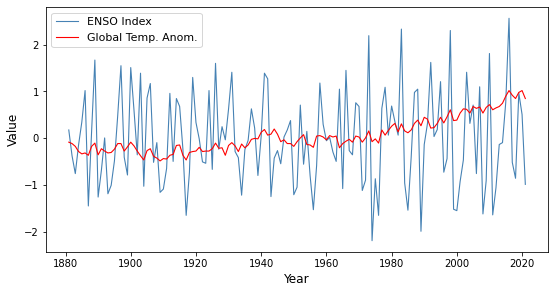

In [7]:
## Make a timeseries plot of the ENSO Index and Global Temperature values
## Look at your Data!!!
fig = plt.figure(figsize=(9,4.5));
plt.plot(years, enso, color='steelblue', lw=1.1,label='ENSO Index');
plt.plot(years, t_sfc, color='red', lw=1.1,label='Global Temp. Anom.');
plt.xlabel("Year",fontsize=12);
plt.ylabel("Value",fontsize=12);
plt.legend(loc='upper left',fontsize=11);

####**Question 1 (10 points)**: Describe both of your data variables.  What are the mean and standard deviation of your data variables? Are the data variables standardized?  Do the data variables have a trend? ####

In [8]:
### put your answer in code format here:

**Answer**: Edit this cell and write your answer here in 1-2 complete sentences.

**STEP 4: Prepare your data for regression analysis.** 

Detrend, and then standardize.  
After this step:
1. both variables should have mean of 0 and a standard deviation of 1.
2. neither variable should have a linear trend.

In [9]:
### FIRST detrend - i.e., removing the linear slope
slope, intercept, r_value, p_value, std_err = stats.linregress(years,t_sfc)
t_dtrend=t_sfc-(years*slope)
print(f'slope: {np.round(slope,2)}')
slope, intercept, r_value, p_value, std_err = stats.linregress(years,enso)
enso_dtrend=enso-(years*slope)
print(f'slope: {np.round(slope,2)}')

## THEN standardize the data (i.e., remove the mean, divide by the standard deviation)
t_dtrend_stand = standardize(t_dtrend)
enso_dtrend_stand = standardize(enso_dtrend)

## check that your data have a mean of 0 and a standard deviation of 1
print(f'mean t: {np.round(np.mean(t_dtrend_stand),1)}')
print(f'mean enso: {np.round(np.mean(enso_dtrend_stand),1)}')
print(f'std t: {np.round(np.std(t_dtrend_stand),1)}')
print(f'std enso: {np.round(np.std(enso_dtrend_stand),1)}')

slope: 0.01
slope: 0.0
mean t: 0.0
mean enso: -0.0
std t: 1.0
std enso: 1.0


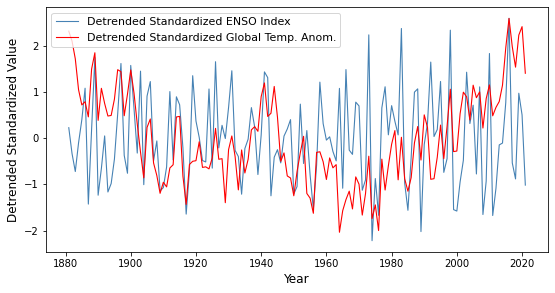

In [10]:
## Make a timeseries plot of standardized/detrended values ENSO and detrended Global Temps
fig = plt.figure(figsize=(9,4.5));
plt.plot(years, enso_dtrend_stand, color='steelblue', lw=1.1,label='Detrended Standardized ENSO Index');
plt.plot(years, t_dtrend_stand, color='red', lw=1.1,label='Detrended Standardized Global Temp. Anom.');
plt.xlabel("Year",fontsize=12);
plt.ylabel("Detrended Standardized Value",fontsize=12);
plt.legend(loc='upper left',fontsize=11);

####**Question 2 (10 points)**: What happens if you do it the other way first standardize, then detrend?? Code that up and print the results.  Do your processed data have a standard deviation of 1 and mean of 0? Why or Why not? ####

**Answer**: Edit this cell and write your answer here in 1-2 complete sentences.

In [11]:
### put your answer in code format here:

**STEP 5: Calculate the linear regression.** 

It seems plausible that sea surface temperatures in the tropical pacific affect the global mean temperature through teleconnections. Thus, here we will test if we can use the ENSO-index (x) to predict the global mean temperature (y).
Global mean temperatures is the independent variable (y-axis) and the ENSO index is the dependent variable (x-axis).  



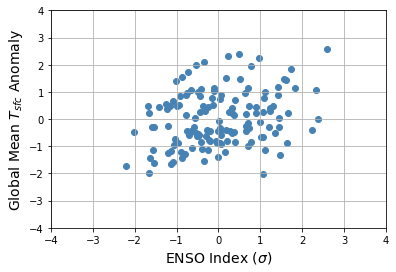

In [12]:
## Start by making a scatter plot for the detrended standardized values of global mean 
## temperature anomalies (y-axis) and the detrended standardized ENSO index (x-axis)
fig = plt.figure(figsize=(6,4));
plt.scatter(enso_dtrend_stand,t_dtrend_stand,c='steelblue');
plt.xlabel("ENSO Index ($\sigma$)",fontsize=14);
plt.ylabel("Global Mean $T_{sfc}$ Anomaly",fontsize=14);
plt.xlim((-4,4));
plt.ylim((-4,4));
plt.grid();

####**Question 3 (10 points)**: After looking at your data, what do you think?  Does it look like the ENSO index can be used to predict the global mean temperature anomaly? Why or Why not? ####

**Answer**: Edit this cell and write your answer here in 2-3 complete sentences.

In [ ]:
### Use linear regression to calculate the slope, y-intercept, r-value, and variance explained.

### Here we will calculate the regression statistics in two ways:

### METHOD #1: Use Barnes Equations - i.e., calculate the values "from scratch"
xdata=np.array(enso_dtrend_stand)
ydata=np.array(t_dtrend_stand)
variancex=np.sum((xdata*xdata))
covariance=np.dot(xdata,ydata)
slope=covariance/variancex ##Barnes Chapter 2, Eq. (14)
intercept=np.mean(ydata)-slope*np.mean(xdata)  ##Barnes Chapter 2, Eq. (15)
variancey=np.sum((ydata*ydata))
r_value=covariance/(np.sqrt(variancex)*np.sqrt(variancey)) ##Barnes Chapter 2, Eq. (31)
print('RESULTS - "from scratch"')
print('Slope, a1 (standard deviation GTS/standard deviation ENSO index):',round(slope,2))
print('Intercept, a0 (standard deviation GTS):', round(intercept,2))
print('R_Value:', round(r_value,2))
print('Percent variance explained:',round((r_value**2)*100,1),'%')
print('\n')

### METHOD #2: Use stats.linregress - you should get the same thing...
print('RESULTS - "using stats.linregress"')
slope, intercept, r_value, p_value, std_err = stats.linregress(enso_dtrend_stand,t_dtrend_stand)
print('Slope, a1 (standard deviation GTS/standard deviation ENSO index):',round(slope,2))
print('Intercept, a0 (standard deviation GTS):', round(intercept,2))
print('R_Value:', round(r_value,2))
print('Percent variance explained:',round((r_value**2)*100,1),'%')

RESULTS - "from scratch"
Slope, a1 (standard deviation GTS/standard deviation ENSO index): 0.29
Intercept, a0 (standard deviation GTS): 0.0
R_Value: 0.29
Percent variance explained: 8.4 %


RESULTS - "using stats.linregress"
Slope, a1 (standard deviation GTS/standard deviation ENSO index): 0.29
Intercept, a0 (standard deviation GTS): 0.0
R_Value: 0.29
Percent variance explained: 8.4 %


####**Question 4 (10 points)**: What is the equation of the line that represents the estimate of y given x based on linear regression? ####

**Answer**: Edit this cell and write your answer here.

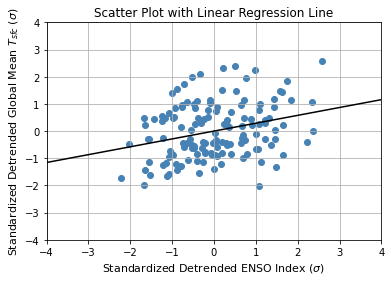

In [ ]:
### Remake the scatter plot and include the Linear Regression Prediction Line (i.e., the line that represents
### the estimate of y. given x based on linear regression)
fit_x = np.arange(-4,4.1,0.1);
fit_y = [];
for i in fit_x:
    fit_y.append(slope*i + intercept)
plt.scatter(enso_dtrend_stand,t_dtrend_stand,c='steelblue');
plt.xlabel("Standardized Detrended ENSO Index ($\sigma$)",fontsize=11);
plt.ylabel("Standardized Detrended Global Mean $T_{sfc}$ ($\sigma$)",fontsize=11);
plt.xlim((-4,4));
plt.ylim((-4,4));
plt.grid();
plt.title("Scatter Plot with Linear Regression Line",fontsize=12);
plt.plot(fit_x,fit_y,c='black');

**STEP 6: Assess statistical significance of the correlation coefficient.** 

Here we will use two different methods.  Note how the methods differ in their null hypotheses, and the resulting statistics that are applied.

In [13]:
### Method #1: H0 (null hypothesis) correlation is 0  ## similar to Barnes Worked Problem 2.1
print('ASSESS SIGNIFICANCE OF REGRESSION METHOD #1')
print('Null Hypothesis: The true correlation is zero. ')
N=len(years)
dof=N-2
print("dof",dof)
tcrit=stats.t.ppf(0.975,N-2)  ## two-sided 95%
print('tcrit=',round(tcrit,2))
t=r_value*np.sqrt(N-2)/np.sqrt((1-r_value*r_value))
print('t=',round(t,2))
if t>tcrit:
  print('Since t=',round(t,2),'exceeds tcrit=',round(tcrit,2),' we can reject the null hypothesis')
elif t<tcrit:
  print('Since t=',round(t,2),'does not exceed tcrit=',round(tcrit,2),' we cannot reject the null hypothesis')

ASSESS SIGNIFICANCE OF REGRESSION METHOD #1
Null Hypothesis: The true correlation is zero. 
dof 139
tcrit= 1.98
t= 0.21
Since t= 0.21 does not exceed tcrit= 1.98  we cannot reject the null hypothesis


####**Question 5 (10 points)**: Write out the formal steps in hypothesis testing for method #1 ####

**Answer**: Edit this cell and write your answer here. Include all 5 steps.

In [ ]:
### Method #2: H0 (null hypothesis) true correlation is not 0.

## Calculate the Fisher-Z Transformation mean, Barnes Ch. 2 Eq. 52
print('ASSESS SIGNIFICANCE OF REGRESSION METHOD #2')
print('Null Hypothesis: The true correlation is not zero.')
mu_Z=0.5*np.log((1+r_value)/(1-r_value)) 
print('mu_Z:',np.round(mu_Z,2))
N=len(years)
df=N-3     ## Calculate the degrees of freedom
sigma_Z=1/np.sqrt(df) ## Calculate the Fisher-Z Transformation standard deviation Barnes Ch. 2 Equation 53
print('sigma_Z:',np.round(sigma_Z,2))

## Calculate the critical value, i.e., the t-statistic
tstat95=stats.t.ppf(0.975,df)  ## two-sided 95%
print('tstat95',round(tstat95,3))
## Calculate the confidence intervals on the mean (mu_Z)
Zmin=mu_Z-tstat95*sigma_Z ## Barnes Ch. 2 Equation 54
Zmax=mu_Z+tstat95*sigma_Z ## Barnes Ch. 2 Equation 54
print('Zmin (minimum 95% confidence interval)',round(Zmin,2))
print('Zmax (maximum 95% confidence interval)',round(Zmax,2))

## Convert to give a confidence interval on the correlation using Barnes Ch. 2 Eq. 55
rho_min=np.tanh(Zmin)
rho_max=np.tanh(Zmax)
print('Rhomin (minimum 95% confidence interval for true r_value):',round(rho_min,2))
print('Rhomax (maximum 95% confidence interval for true r_value):',round(rho_max,2))

print('If the confidence bounds do include 0 -- we reject the null hypothesis')
print('If the confidence bounds do not include 0 -- we fail to reject the null hypothesis')

ASSESS SIGNIFICANCE OF REGRESSION METHOD #2
Null Hypothesis: The true correlation is not zero.
mu_Z: 0.3
sigma_Z: 0.09
tstat95 1.977
Zmin (minimum 95% confidence interval) 0.13
Zmax (maximum 95% confidence interval) 0.47
Rhomin (minimum 95% confidence interval for true r_value): 0.13
Rhomax (maximum 95% confidence interval for true r_value): 0.43
If the confidence bounds do include 0 -- we reject the null hypothesis
If the confidence bounds do not include 0 -- we fail to reject the null hypothesis


####**Question 6 (10 points)**: Write out the formal steps in hypothesis testing for method #2 ####

**Answer**: Edit this cell and write your answer here. Include all 5 steps.

####**Question 7 (10 points)**: Do Method #1 and Method #2 agree?  What can you conclude? ####

**Answer**: Edit this cell and write your answer here.

**STEP 7: Use the lag-1 autocorrelation (alpha) to calculate the number of independent samples (N*) in both data variables** 

In [ ]:
# Calculate the autocorrelation using numpy dot (direct calculation)
# (https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.dot.html)
tseries1=t_dtrend_stand
n=len(tseries1)
sigma=1
lag=1
alpha=np.dot(tseries1[0:-1*lag],tseries1[lag:])/(n-lag)/sigma**2 ## Barnes Chapter 2 Eq. 68 divided by the variance
print('lag',lag,'t_srf autocorrelation:',round(alpha,3))
## calculate N*
t_nstar=round((1-np.abs(alpha))/(1+np.abs(alpha))*n,0) ## Chapter 2 Barnes Eq. 88
print('#independent samples, N*: ',t_nstar) 

lag 1 t_srf autocorrelation: 0.783
#independent samples, N*:  17.0


In [ ]:
# Calculate the autocorrelation using numpy dot (direct calculation)
# (https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.dot.html)
tseries1=enso_dtrend_stand
n=len(tseries1)
sigma=1
lag=1
alpha=np.dot(tseries1[0:-1*lag],tseries1[lag:])/(n-lag)/sigma**2 ## Barnes Chapter 2 Eq. 68 divided by the variance
print('lag',lag,'ENSO autocorrelation:',round(alpha,3))
## calculate N*
enso_nstar=round((1-np.abs(alpha))/(1+np.abs(alpha))*n,0) ## Chapter 2 Barnes Eq. 88
print('#independent samples, N*: ',enso_nstar)

lag 1 ENSO autocorrelation: -0.086
#independent samples, N*:  119.0


####**Question 8 (10 points)**: Based on your calculation of the lag-1 autocorrelation - which variable has more memory? In other words, which variable is redder and which variable is whiter?  How does memory affect the number of independent samples (N*)?####

**Answer**: Edit this cell and write your answer here.

**STEP 8: Re-Assess the statistical significance of the correlation using N* instead of N** 

In [ ]:
## here we will be conservative and use the smaller of the two N* values
Nstar=min(t_nstar,enso_nstar)
print(Nstar)

17.0


In [ ]:
### Method #1: H0 (null hypothesis) correlation is 0  ## similar to Barnes Worked Problem 2.1
print('ASSESS SIGNIFICANCE OF REGRESSION METHOD #1')
print('Null Hypothesis: The true correlation is zero. ')
N=Nstar
dof=N-2
print("dof",dof)
tcrit=stats.t.ppf(0.975,N-2)  ## two-sided 95%
print('tcrit=',round(tcrit,2))
t=r_value*np.sqrt(N-2)/np.sqrt((1-r_value*r_value))
print('t=',round(t,2))
if t>tcrit:
  print('Since t=',round(t,2),'exceeds tcrit=',round(tcrit,2),' we can reject the null hypothesis')
elif t<tcrit:
  print('Since t=',round(t,2),'does not exceed tcrit=',round(tcrit,2),' we cannot reject the null hypothesis')

ASSESS SIGNIFICANCE OF REGRESSION METHOD #1
Null Hypothesis: The true correlation is zero. 
dof 15.0
tcrit= 2.13
t= 1.17
Since t= 1.17 does not exceed tcrit= 2.13  we cannot reject the null hypothesis


In [ ]:
## Calculate the Fisher-Z Transformation mean, Barnes Ch. 2 Eq. 52
print('ASSESS SIGNIFICANCE OF REGRESSION METHOD #2')
print('Null Hypothesis: The true correlation is not zero.')
mu_Z=0.5*np.log((1+r_value)/(1-r_value)) 
print('mu_Z:',np.round(mu_Z,2))
N=len(years)
df=N-3     ## Calculate the degrees of freedom
sigma_Z=1/np.sqrt(df) ## Calculate the Fisher-Z Transformation standard deviation Barnes Ch. 2 Equation 53
print('sigma_Z:',np.round(sigma_Z,2))

## Calculate the critical value, i.e., the t-statistic
tstat95=stats.t.ppf(0.975,df)  ## two-sided 95%
print('tstat95',round(tstat95,3))
## Calculate the confidence intervals on the mean (mu_Z)
Zmin=mu_Z-tstat95*sigma_Z ## Barnes Ch. 2 Equation 54
Zmax=mu_Z+tstat95*sigma_Z ## Barnes Ch. 2 Equation 54
print('Zmin (minimum 95% confidence interval)',round(Zmin,2))
print('Zmax (maximum 95% confidence interval)',round(Zmax,2))

## Convert to give a confidence interval on the correlation using Barnes Ch. 2 Eq. 55
rho_min=np.tanh(Zmin)
rho_max=np.tanh(Zmax)
print('Rhomin (minimum 95% confidence interval for true r_value):',round(rho_min,2))
print('Rhomax (maximum 95% confidence interval for true r_value):',round(rho_max,2))

print('If the confidence bounds do include 0 -- we reject the null hypothesis')
print('If the confidence bounds do not include 0 -- we fail to reject the null hypothesis')

ASSESS SIGNIFICANCE OF REGRESSION METHOD #2
Null Hypothesis: The true correlation is not zero.
mu_Z: 0.3
sigma_Z: 0.09
tstat95 1.977
Zmin (minimum 95% confidence interval) 0.13
Zmax (maximum 95% confidence interval) 0.47
Rhomin (minimum 95% confidence interval for true r_value): 0.13
Rhomax (maximum 95% confidence interval for true r_value): 0.43
If the confidence bounds do include 0 -- we reject the null hypothesis
If the confidence bounds do not include 0 -- we fail to reject the null hypothesis


####**Question 9 (10 points)**: Do Method #1 and Method #2 agree?  What can you conclude?  How does using N* instead of N affect the results?####

**Answer**: Edit this cell and write your answer here in 2-3 sentences.

**STEP 9: Use plain everyday language.  What did you learn?** 

####**Question 10 (10 points)**: Explain to your friend in plain every day langauge assuming that they have not taken any statistics course.  What is your overall conclusion from this application lab?  Can x (ENSO index) be used to predict y (global mean temperature)?  Does accounting for autocorrelation in your data variables change the conclusion? ####

**Answer**: Edit this cell and write your answer here in 2-3 sentences.  Points only given for language that is easy to understand by a non-specialist.

## END OF APPLICATION LAB #2 - Congratulations!! ##